<a href="https://colab.research.google.com/github/arincons2/RecommendationSystem/blob/main/ARINCON_RecSyst_Fullcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [ ]:
!pip install surprise #______________________

## **Importing the necessary libraries and overview of the dataset**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Basic python libraries
import numpy as np
import pandas as pd

# Python libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict

# For implementing cross validation
from surprise.model_selection import KFold

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df_copy**

In [ ]:
#path with data
path_ratingselectronics="/content/drive/MyDrive/COLAB_PROJECT3_week11/ratings_Electronics.csv"
df = pd.read_csv(path_ratingselectronics)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   AKM1MP6P0OYPR  object 
 1   0132793040     object 
 2   5.0            float64
 3   1365811200     int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [ ]:
df.shape

(7824481, 4)

**Observations of mine:**\
There are 7'824 481 rows and 4 columns in the data.

In [ ]:
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] # Adding column names

df = df.drop('timestamp', axis = 1) # Dropping timestamp

df_copy = df.copy(deep = True) # Copying the data to another DataFrame
#ratings_Electronics.csv

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [ ]:
df.head()

,user_id,prod_id,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
#ratings_counts.value_counts()

In [ ]:
#print('Valores de ratings_count',ratings_count.head(10))

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

In [ ]:
df_final.shape

(65290, 3)

**Observations of mine:**\
-The final size is 65290 rows, and 3 columns
-

### **Check the number of rows and columns and provide observations.**

In [ ]:
print('The number of rows is:',len(df_final))

The number of rows is: 65290


In [ ]:
# Check the number of rows and columns and provide observations
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


In [ ]:
df_final.tail()

,user_id,prod_id,rating
7824422,A34BZM6S9L7QI4,B00LGQ6HL8,5.0
7824423,A1G650TTTHEAL5,B00LGQ6HL8,5.0
7824424,A25C2M3QF9G7OQ,B00LGQ6HL8,5.0
7824425,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0
7824426,A2NYK9KWFMJV4Y,B00LGQ6HL8,5.0


**Write your observations here:**\
- there are 65290 rows and 3 columns in the new data

### **Data types**

In [ ]:
# Check Data types and provide observations
df_final.info()#__________

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Write your observations here:**\
- from the whole data, there are no 'null' data
- the 'user_id' column data is an object (a name)
- the 'prod_id' column data is an object (a name)
- the 'rating' column data is real number (float)


### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
df_final.isna().sum() #___________

user_id    0
prod_id    0
rating     0
dtype: int64

In [ ]:
df_final.duplicated().sum()

0

**Write your observations here:**\
- there aren't missing values
- there aren't duplicated values


### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
#df[num_cols].describe(include='all').T
df_final.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user_id,65290,1540,ADLVFFE4VBT8,295,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prod_id,65290,5689,B0088CJT4U,206,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,65290.0,NaN,NaN,NaN,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0


**Write your observations here:**\
- for 'rating' column: the lowest value is 1.0; the highest value is '5.0'; the median is 5.0; and the mean is 4.3.
- the minimum and maximum values are logical (realistic), so that all the data are valid and deleting data is not necessary.
- Number of products and users:  
 - the 'user_id' column comprises 1540 unique values, what meas that there are 1540 users
 - the 'prod_id' column comprises 5689 unique values, what means that there are 5689 different products.
 - **the above values indicate that the number of products is significantly higher than the number of users**.


### **Checking the rating distribution**

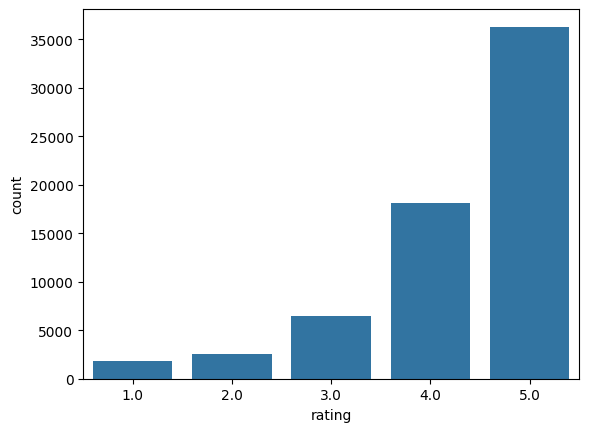

In [ ]:
# Create the bar plot and provide observations
sns.countplot(data=df_final, x='rating') ;

**Write your observations here:**\
- the data seem to be highly skewed towards rating '5';
 rating '5' is the highest in the count,
 and rating '4' is the second-highest.
- we can see that very few people give ratings between '1' to '3'. It indicates that people tend to not give a rating for a product that they don't like.

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data
print('Number of total rows is:',len(df_final))
print('number of unique users is:',df_final['user_id'].nunique())
print('number of unique products is:',df_final['prod_id'].nunique())

Number of total rows is: 65290
number of unique users is: 1540
number of unique products is: 5689


**Write your observations here:**\
- There are **1540 unique users** in the dataset.
- There are **5689 unique products** in the dataset.
- As per the number of unique users and restaurants, there is a **possibility of 1540 * 5689 = 8'761 060 ratings** in the dataset. But **we only have 65 290 ratings**, i.e., not every user has rated every product in the dataset.
-And we can build a recommendation system to recommend a product to users which they have not interacted with.

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
df_final['user_id'].value_counts().nlargest(11)

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
A3LGT6UZL99IW1    179
Name: count, dtype: int64

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


In [ ]:
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


**Write your observations here:**\
- the user with id number ADLVFFE4VBT8 has interacted the most: it has interacted 295 times.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
avg_rating_perprodt = df_final.groupby(['prod_id'])['rating'].mean()

In [ ]:
# Calculate the count of ratings for each product
count_ratings_perprodt = df_final.groupby(['prod_id'])['rating'].count()

#df_final['prod_id'].value_counts()

In [ ]:
# Create a dataframe with calculated average and count of ratings
DataFrame_Avg_nCount = pd.DataFrame({'avg_rating':avg_rating_perprodt, 'rating_count':count_ratings_perprodt})
DataFrame_Avg_nCount.head()
#final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

,avg_rating,rating_count
prod_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5


In [ ]:
# Sort the dataframe by average of ratings in the descending order
DataFrame_Avg_nCount.sort_values(by='avg_rating',ascending=False)#.head()
#   df.sort_values(by='Forks',ascending=False, ignore_index=True).head()
#   DataFrame_Avg_nCount.groupby(['avg_rating']).value_counts()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.000000,5
B003DZJQQI,5.000000,14
B005FDXF2C,5.000000,7
B00I6CVPVC,5.000000,7
B00B9KOCYA,5.000000,8
...,...,...
B003O2RVGM,1.833333,12
B000ND75C0,1.833333,6
B007C0Y7RI,1.625000,8


In [ ]:
# See the first five records of the "final_rating" dataset
DataFrame_Avg_nCount.head()

,avg_rating,rating_count
prod_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(data, n, min_interaction):

    # Finding products with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]

    # Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False)

    return recommendations.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
list(top_n_products(DataFrame_Avg_nCount, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
list(top_n_products(DataFrame_Avg_nCount, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


**Write your observations here (user-user based non-tuned Rec Syst):**\
- The baseline (non-tuned) model is giving a F-1 score of 0.856%.
- It indicates an excellent performance by the model, despite the fact that it doesn't have tuning.


Let's now **predict rating for a user with `Id=A3LDPF5FMB782Z` and product with `Id=1400501466` (known interaction)** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
print('Verification of the ratings given by the user A3LDPF5FMB782Z to the product 1400501466:')
print(df_final.loc[(df_final['user_id'] == 'A3LDPF5FMB782Z') & (df_final['prod_id'] == '1400501466')])
#df.loc[(df['max_speed'] > 1) & (df['shield'] < 8)]

Verification of the ratings given by the user A3LDPF5FMB782Z to the product 1400501466:
             user_id     prod_id  rating
1309  A3LDPF5FMB782Z  1400501466     5.0


In [ ]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

**Write your observations here (known interaction):**\
- The estimated rating is 3.4, which is quite far from the real value (5.0).
 **This is a very bad prediction!!!!**
- This implies that it is overly important to tune its parameters, and also try better models.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
print('list of DataFrame points for which prod_id is not equal to 1400501466:')
print(df_final.loc[df_final['prod_id'] != '1400501466'])

list of DataFrame points for which prod_id is not equal to 1400501466:
                user_id     prod_id  rating
2081     A2ZR3YTMEEIIZ4  1400532655     5.0
2149     A3CLWR1UUZT6TG  1400532655     5.0
2161      A5JLAU2ARJ0BO  1400532655     1.0
2227     A1P4XD7IORSEFN  1400532655     4.0
2362     A341HCMGNZCBIT  1400532655     5.0
...                 ...         ...     ...
7824422  A34BZM6S9L7QI4  B00LGQ6HL8     5.0
7824423  A1G650TTTHEAL5  B00LGQ6HL8     5.0
7824424  A25C2M3QF9G7OQ  B00LGQ6HL8     5.0
7824425   A1E1LEVQ9VQNK  B00LGQ6HL8     5.0
7824426  A2NYK9KWFMJV4Y  B00LGQ6HL8     5.0

[65284 rows x 3 columns]


In [ ]:
#df_not_seen_ProdId = df_final.loc[df_final['prod_id'] != '1400501466']

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466` (unknown interaction).**

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here (unknown interaction):**\
As we can see the estimated rating for this user-item pair is 4.29 based on this similarity (user-user) based baseline (non-tuned) model.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


0.9717946963781684
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 40, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)


RMSE: 0.9526
Precision:  0.847
Recall:  0.894
F_1 score:  0.87


**Write your observations here:__________**\
- We can see from above that after tuning hyperparameters, F_1 score of the tuned model has increased a bit as compared to the baseline model (Recall that the F1 score of the non-tuned model is 0.856).
- Then, altough the increase is not high, the 0.87 value is a high F1 value.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

**Now, we predict the rating for the user with `Id="A3LDPF5FMB782Z"`, and product with `id= "1400501466"` (known interaction) using the optimized model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here (known interaction):**\
Discussion on the results of the tuned model for known user-item interaction:\
- As we can see the estimated rating based on this similarity based tuned model is 4.29, which is relatively good, taking into account that the real value is 5.0.
- Recall that the estimated rating with the non-tuned model is 3.4.  **Therefore, the tuning has been overly effective!!!!**.

**Now, we predict the rating for user with `Id="A34BZM6S9L7QI4"` and product with `id ="1400501466"` (unknown interaction), by using the optimized model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here (unknown interaction):**\
Discussion on the results of the tuned model for unknown user-item interaction:\
- As we can see the estimated rating for this user-item pair is 4.29 based on this similarity based tuned model; \
 whereas the estimated rating was 4.29 based on the non- tuned model.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0, 5)

[6, 7, 17, 26, 32]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400599997,5
1,B00000DM9W,5
2,B00000K4KH,5
3,B00001W0DI,5
4,B00002EQCW,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items. Use random_state=1
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


**Write your observations here:**____________\
- The baseline model is giving an F_1 score of **about 84%**. This is an excellent score. Also, it is an excellent score taking into account that it has not been tuned yet.  
- We will try to **improve this later by using GridSearchCV** by tuning different hyperparameters of this algorithm.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466` (known interaction)** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

**Write your observations here (known interaction):**\
The predicted rating (4.27) is relatively good here for a product whose actual rating is **5.0**. Then, the non-optimized model is giving a relatively good prediction.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`** (which are non-interacted).

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here (unknown interaction):**\
For an unseen product the rating given by the model is 4.29.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


0.9746882569283701
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)


RMSE: 0.9576
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


**Write your observations here:__________**\
- We can see from above that after tuning hyperparameters, **F_1 score of the tuned model is a little better than the baseline (non tuned) model (Recall that the F1 of the non-tuned model is 0.841)**.
- Also, there is a little fall in the RMSE value after tuning the hyperparameters (The RMSE of the non-tuned model is 0.9950).
- Hence **the tuned model is doing better (only a littlle better) than the earlier one!!!**.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

**Now we predict the rating for a user with `Id = "A3LDPF5FMB782Z"` and product with Id `"1400501466"`** (which is a **known** interaction)

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.67   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.67427701674277, details={'actual_k': 22, 'was_impossible': False})

**Write your observations here: (known interaction)**\
- Here the optimized model predicting the rating 4.67 for the known user-item interaction whose actual rating is 5.0.
- This result is relatively good, and it is much better than previous result obtained with the non-tuned model (recall that the rating given by the non-tuned model is 4.27).
- Then, in this case **the optimization has been overly useful!!!!!**.

**Now we predict the rating for a user with `Id = "A34BZM6S9L7QI4"` and product with Id `"1400501466"`** (which is an unknown interaction)

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_item_item_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:__________**\
For an unknown product the model is predicting a rating of 4.29.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
sim_item_item_optimized.get_neighbors(0, k = 5)

[29, 53, 67, 106, 151]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state = 1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


**Write your observations here:___________**\
- The baseline (non-tuned) model with the algorithm is giving a F-1 score of 0.87%.
- It is an excellent performance of the model, despite the fact that is has not been tuned.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`** (which is a **known** interaction).

In [ ]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

**Write your observations here: (known interaction)**\
- The predicted rating (4.08) is relatively good here for a product whose actual rating is **5.0**.
- Then, the model is giving a relatively good prediction.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`** (which is an unknown interaction).

In [ ]:
# Making prediction
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

**Write your observations here: (unknown interaction)**\
- For an unseen product the rating given by the optimized model is 4.4.



### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


0.8978563036299788
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs = 20, lr_all = 0.01, reg_all = 0.2, random_state = 1)

# Train the algorithm on the trainset
svd_optimized = svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)


RMSE: 0.8808
Precision:  0.854
Recall:  0.878
F_1 score:  0.866


**Write your observations here: (tuned model)**\
- We can see from above that the **tuned model** is showing the same F_1 (almost the same) score than the baseline model (recall that the F1 score for the non-tuned model is 0.866)
- Also, we can see that  the RMSE has slightly decreased (recall that the RMSE for the non-tuned model is 0.888).
- Hence **the performance of the tuned model is almost the same as that of the earlier (non-tuned) model**.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

**Now we predict the rating for the user with userId="A3LDPF5FMB782Z", and prod_id= "1400501466" using the optimized model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.13   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.128589011282042, details={'was_impossible': False})

**Observation (known interaction)**:\
- The predicted rating (4.13) is relatively good here for a product whose actual rating is **5.0**. Then, the optimized model is giving a relatively good prediction.
- Recall that the rating given by the non-tuned model is 4.08. Threfore, the prediction capability has almost remained the same. That is, **the tuning has had almost no effect** on the prediction of known user-item interaction.

**Now we predict the rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "zp713qNhx8d9KCJJnrw1xA", verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: zp713qNhx8d9KCJJnrw1xA r_ui = None   est = 4.29   {'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=4.292024046561495, details={'was_impossible': False})

 **Observation (unknown interaction)**: \
For an unseen product the rating given by the optimized model is 4.29.

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**\

<ul type = 'disc'>
  <li>In this case study, we built recommendation systems using different algorithms. They are as follows
  <ul>
    <li>Model 1: rank based recommendation system (based on averages)  
    <li>Model 2: collaborative filtering recommendation system:
      <ul>
       <li>a) user-user similarity based (KNNBasic model); and tuned model
       <li>b) item-item similarity based (KNNBasic model) and tuned model
      </ul>
    <li>Model 3: matrix factorization collaborative filtering: singular value decomposition -SVD, and tuned model
  </ul>
</ul>

- We have seen how they are different from each other and what kind of data is needed to build each of these recommendation systems. We can further combine all the recommendation techniques we have seen.

- To apply **"user-user-similarity-based collaborative filtering"**, **"item-item-similarity-based collaborative filtering"**, and **"model-based (matrix factorization) collaborative filtering"**, the **surprise** library has been used. For these algorithms **grid search cross-validation** (optimization) is applied to find the best working model (that is, the best parameters), and these parameters are then used in the determination of the predictions for certain user-item combinations, including a known user-item interaction and an unknown user-item combination.

- **For performance evaluation** of these models **precision@k and recall@k** are introduced in this case study. Using these two metrics **F_1 score** is calculated for each working model.
- We have predicted the ratings for all the users that have not interacted with a particular product.



#Main results:
In the application of "user-user-similarity-based collaborative filtering", "item-item-similarity-based collaborative filtering", and "matrix factorization collaborative filtering", the main results are:

In [ ]:
data_table = {'RMSE (tuned)': ['0.953','0.957','0.881'],
              'F1 (tuned)': ['0.869', '0.863', '0.866'],
        'Prediction (tuned)': [4.29, 4.67, 4.13],
              'Prediction (non-tuned)': [3.4, 4.27, 4.08]
              }

df_datatable = pd.DataFrame(data_table, index=['collaborative user-user',
                               'collaborative item-item',
                               'matrix factorization'])
print(df_datatable)

                        RMSE (tuned) F1 (tuned)  Prediction (tuned)  \
collaborative user-user        0.953      0.869                4.29   
collaborative item-item        0.957      0.863                4.67   
matrix factorization           0.881      0.866                4.13   

                         Prediction (non-tuned)  
collaborative user-user                    3.40  
collaborative item-item                    4.27  
matrix factorization                       4.08  


where 'Prediction' corresponds to the prediction of the known user-item interaction, whose real rating value is 5.0.
- From the above results it follows that the highest F1 was achieved by the 'tuned collaborative user-user' method, but the differences between the F1 values is almost negligible; that is, the F1 values are almost the same.
- **the lowest RMSE was achieved by the tuned matrix factorization method**.   
- **the best prediction of the known user-item interaction was acheived by the 'tuned collaborative item-item' method**. The worst prediction is given by the matrix factorization method.
- In the cases of 'collaborative user-user' and 'collaborative item-item' methods, the tuning has resulted in a significant improvement of the prediction of the known user-item interaction.  
-The 'collaborative user-user' and 'collaborative item-item' methods have resulted in better prediction of the known user-item interaction, compared to the 'matrix factorization (svd)' method.

#### **Proposal for the final solution design:**

We recommend to use:

- The tuned item collaborative recommendation system (item-item-similarity-based collaborative filtering), since it gives a good (high) F1 score and it has an higher capability for predicting known user-product interaction.
- The tuned matrix factorization method, since it achieved the lowest RMSE, and also it achieved a good F1 score. However, it was the worst in terms of prediction of the known user-item interaction.        

